In [12]:
import numpy as np
import matplotlib.pyplot as plt

n_rep=1

def encode(pos, res = None):
    if res is None: res = 10

    pos = np.array (pos)
    if len (pos.shape) == 1: pos = pos.reshape (-1, 1)
    shape = pos.shape

    x =  np.clip(pos.T, -.5,.5).T

    mu_x = np.linspace (-.5,.5, num = res).T
    s_x= np.diff ((-.5,.5), axis = 0).T / (res)

    enc_x = np.exp (-0.5 * ((x.reshape (-1, 1) - mu_x) / s_x)**2).T

    return np.array (enc_x)


sigma_res_noise = 0.005
sigma_S = 0.002*0

additional_description = '1'


[0.6195706]
[0.52781172]
[0.61583119]
[0.58627907]
[0.66418075]


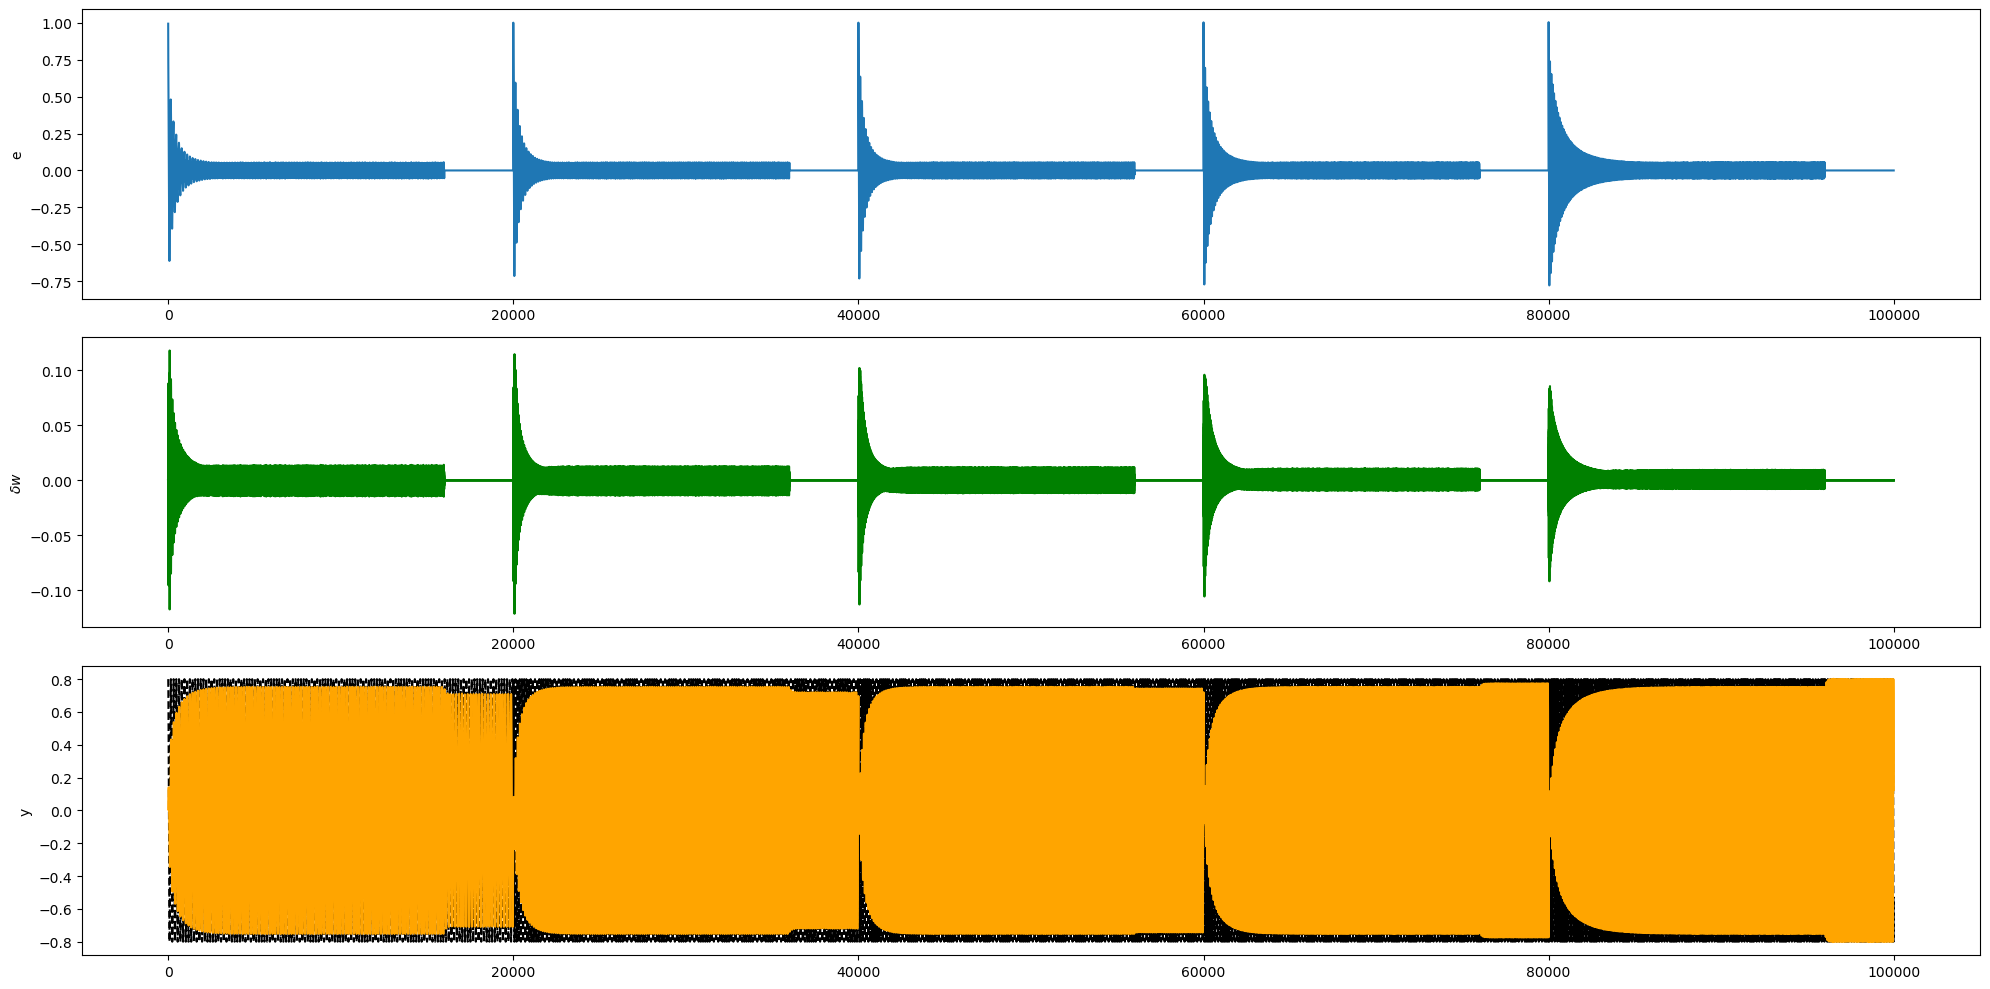

In [13]:
condition=0

#while (condition==0 ):
for kkk in range(1):

    ERRORS = []

    from goal_onr import RESERVOIRE_SIMPLE_NL
    from goal_onr import RESERVOIRE_SIMPLE_NL_MULT_OUT

    N, I, O, TIME = 100, 15, 7, 600
    shape = (N, I, O, TIME)

    dt = .005# / T;
    tau_m_f = 20. * dt
    tau_m_s = 20. * dt
    tau_s = 2. * dt
    tau_ro = .001 * dt
    beta_s  = np.exp (-dt / tau_s)
    beta_ro = np.exp (-dt / tau_ro)
    sigma_teach = 0.
    sigma_input = .06
    sigma_rec = 0.5/np.sqrt(N)
    offT = 1
    dv = 5.
    alpha_rout = .0005;#0.1#.00002;
    alpha_pg = 0.0005
    alpha = 0.
    Vo = 0
    h = 0
    s_inh = 0
    sigma_output = .1

    n_electrodes = 85
    n_pca = n_electrodes

    # Here we build the dictionary of the simulation parameters
    par = {'tau_m_f' : tau_m_f,'tau_m_s' : tau_m_s, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'beta_ro' : beta_ro,
        'dv' : dv, 'alpha' : alpha, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
        'N' : N, 'T' : TIME, 'dt' : dt, 'offT' : offT, 'alpha_rout' : alpha_rout,
        'sigma_input' : sigma_input, 'sigma_teach' : sigma_teach,'sigma_rec' : sigma_rec, 'shape' : shape,'sigma_output':sigma_output};

    # Here we init our model


    # scalar product network
    N=500
    gamma = .5#.5
    input_dim = 20
    e_encoding_dim = 10
    par['tau_m_s'] = 1.*dt
    par['tau_m_f'] = 1.*dt
    shape = ( N , input_dim * 2 , 1 , TIME )
    par['shape']=shape
    network_reservoire = RESERVOIRE_SIMPLE_NL_MULT_OUT (par)
    network_reservoire.Jin_mult = np.random.normal(0,0.1,size=(N,input_dim))

    # reservoire network
    
    shape = ( input_dim , 1, 1 , TIME )
    par['sigma_rec'] = .99/np.sqrt(input_dim)
    par['shape']=shape
    par['tau_m_s'] = 10.*dt
    par['tau_m_f'] = 10.*dt
    par['sigma_input'] = 0.1
    network_reservoire_y = RESERVOIRE_SIMPLE_NL (par)
    network_reservoire_y.Jin_mult = np.random.normal(0,0.1,size=(N,input_dim))

    ## gradient network
    N = 500
    gamma_grad = 1.5
    input_dim = network_reservoire_y.N
    shape = ( N , input_dim + e_encoding_dim , input_dim , TIME )
    par['shape']=shape
    par['sigma_input'] = sigma_input
    par['sigma_rec'] = 0./np.sqrt(N)
    par['tau_m_s'] = 1.*dt
    par['tau_m_f'] = 1.*dt
    network_reservoire_gradient = RESERVOIRE_SIMPLE_NL_MULT_OUT (par)
    network_reservoire_gradient.Jin_mult = np.random.normal(0,0.1,size=(N,1))

    alpha_w = 0.05

    dw = 0

    r_traj = []
    e_traj = []
    dw_traj = []
    r_targ = []
    y_data = []
    S = []


    x_net_coll = []
    y_coll = []

    x_grad_net_coll = []
    y_grad_coll = []

    x_w_coll = []
    y_w_coll = []

    time_tot= 20000

    dt = 0.1

    training_fraction = 0.8

    omega_vals_train = [0.04,0.05,0.06,0.07,0.08]#0.1
    

    for omega_val in omega_vals_train:


        network_reservoire_y.reset()

        eta = .125*.5

        network_reservoire_y.y = np.array(np.random.normal(0,1.,(1,)))

        network_reservoire_y.Jout = np.random.normal (0.0, par['sigma_output'], size = (network_reservoire_y.O,network_reservoire_y.N)) 

        w = np.copy(network_reservoire_y.Jout)
        T = 200

        #y_targ = 0
        y_targ = np.cos(0)
        network_reservoire_y.y = np.copy(np.array([y_targ]))

        grad_accumuluator = 0
        dw = np.zeros(np.shape(w))
        w_filt = np.zeros(np.shape(w))
        dw_filt = np.zeros(np.shape(w))

        network_reservoire.reset()
        network_reservoire_gradient.reset()
        e=0

        for k in range(500):
        
            if k>-1:#time_tot/2:
                input = np.copy( network_reservoire_y.y )
            
            #input = input + np.random.normal(0,1.,np.shape(input))

            network_reservoire_y.step_rate(input,sigma_S)

            encoded_e = encode(0)
            input = np.concatenate((encoded_e , np.reshape(network_reservoire_y.S , (np.shape(network_reservoire_y.S)[0],1  ) ) )  )#np.concatenate(( network_reservoire_y.S , encoded_e ))
            input= np.reshape(input,(np.shape(input)[0],))
            input_modulation = 1 + gamma_grad*network_reservoire_gradient.Jin_mult*e
            input_modulation= np.reshape(input_modulation,(np.shape(input_modulation)[0],))

            network_reservoire_gradient.step_rate(input,input_modulation,0)

            input = np.concatenate((network_reservoire_y.S.reshape(np.shape(network_reservoire_y.S)[0],1),w.T))
            input= np.reshape(input,(np.shape(input)[0],))
            
            input_modulation = 1 + gamma*network_reservoire.Jin_mult@w.T
            input_modulation= np.reshape(input_modulation,(np.shape(input_modulation)[0],))
            
            network_reservoire.step_rate(input,input_modulation.T,0)

        w = np.copy(network_reservoire_y.Jout)

        Err = 0
        for k in range(time_tot):

            state = np.cos( k*omega_val )*.8
            y_targ_old = np.copy(y_targ)

            y_targ = np.copy(state)
            r_targ.append(y_targ )
            data_ndx = np.copy(k)

            S.append(network_reservoire_y.S)

            y_data.append(y_targ)

            if k<(time_tot*training_fraction):
                input = np.copy( np.array([ y_targ_old ]  ) )
                input = input + np.random.normal(0,sigma_res_noise,np.shape(input))
            else:
                input = np.copy(network_reservoire_y.y)
                input = input + np.random.normal(0,sigma_res_noise,np.shape(input))

            network_reservoire_y.step_rate(input,sigma_S)

            e = np.copy(y_targ_old - network_reservoire_y.y)

            if k>(time_tot*training_fraction):
                Err = Err+e**2
                e = np.copy(e*0)
                
            encoded_e = encode(e)
            input = np.concatenate((encoded_e , np.reshape(network_reservoire_y.S , (np.shape(network_reservoire_y.S)[0],1  ) ) )  )#np.concatenate(( network_reservoire_y.S , encoded_e ))
            input = np.reshape(input,(np.shape(input)[0],))
            input_modulation = 1 + gamma_grad*network_reservoire_gradient.Jin_mult*e
            input_modulation = np.reshape(input_modulation,(np.shape(input_modulation)[0],))

            network_reservoire_gradient.step_rate(input,input_modulation,0)

            dw =  network_reservoire_y.S*e
            w_old = np.copy(w) 
            w = w + dw*eta
            

            dw_targ = w-w_old

            input = np.concatenate((network_reservoire_y.S.reshape(np.shape(network_reservoire_y.S)[0],1),w.T))
            input= np.reshape(input,(np.shape(input)[0],))
            
            input_modulation = 1 + gamma*network_reservoire.Jin_mult@w.T
            input_modulation= np.reshape(input_modulation,(np.shape(input_modulation)[0],))
            network_reservoire.step_rate(input,input_modulation.T,0)
            
            network_reservoire_y.Jout = np.copy(w)
            r2 = w@network_reservoire_y.S

            if k<(time_tot*training_fraction*10):
            
                x_net_coll.append(network_reservoire.S)
                y_coll.append(r2)

                x_grad_net_coll.append(network_reservoire_gradient.S)
                y_grad_coll.append(dw_targ.T)

                r_traj.append(network_reservoire_y.y)
                e_traj.append(e)
                dw_traj.append(dw)
        print(Err/time_tot/(1-training_fraction))
        ERRORS.append(Err/time_tot/(1-training_fraction))

    plt.figure(figsize=(20,10))

    plt.subplot(311)

    plt.plot(np.array(e_traj))
    plt.ylabel('e')

    plt.subplot(312)

    plt.plot(dw_traj,'g')
    plt.ylabel('$\delta w$')

    plt.subplot(313)

    plt.plot(r_targ,'k--')
    plt.plot(r_traj,'orange')

    plt.ylabel('y')


    plt.tight_layout()
    plt.savefig('network_dyn.png')
    plt.savefig('network_dyn.pdf')
    
    if (np.max(np.array(ERRORS))<0.1):
        condition = 1

#print(e)

In [14]:
input = np.concatenate((network_reservoire_y.S.reshape(np.shape(network_reservoire_y.S)[0],1),w.T))
input= np.reshape(input,(np.shape(input)[0],))
inp_modulation = 1 + gamma*network_reservoire.Jin_mult@w.T
H = (  network_reservoire.Jin @ input )* (inp_modulation.T) 
print(np.shape(H))

(1, 500)


In [15]:
np.max(np.array(ERRORS))

0.6641807487516452

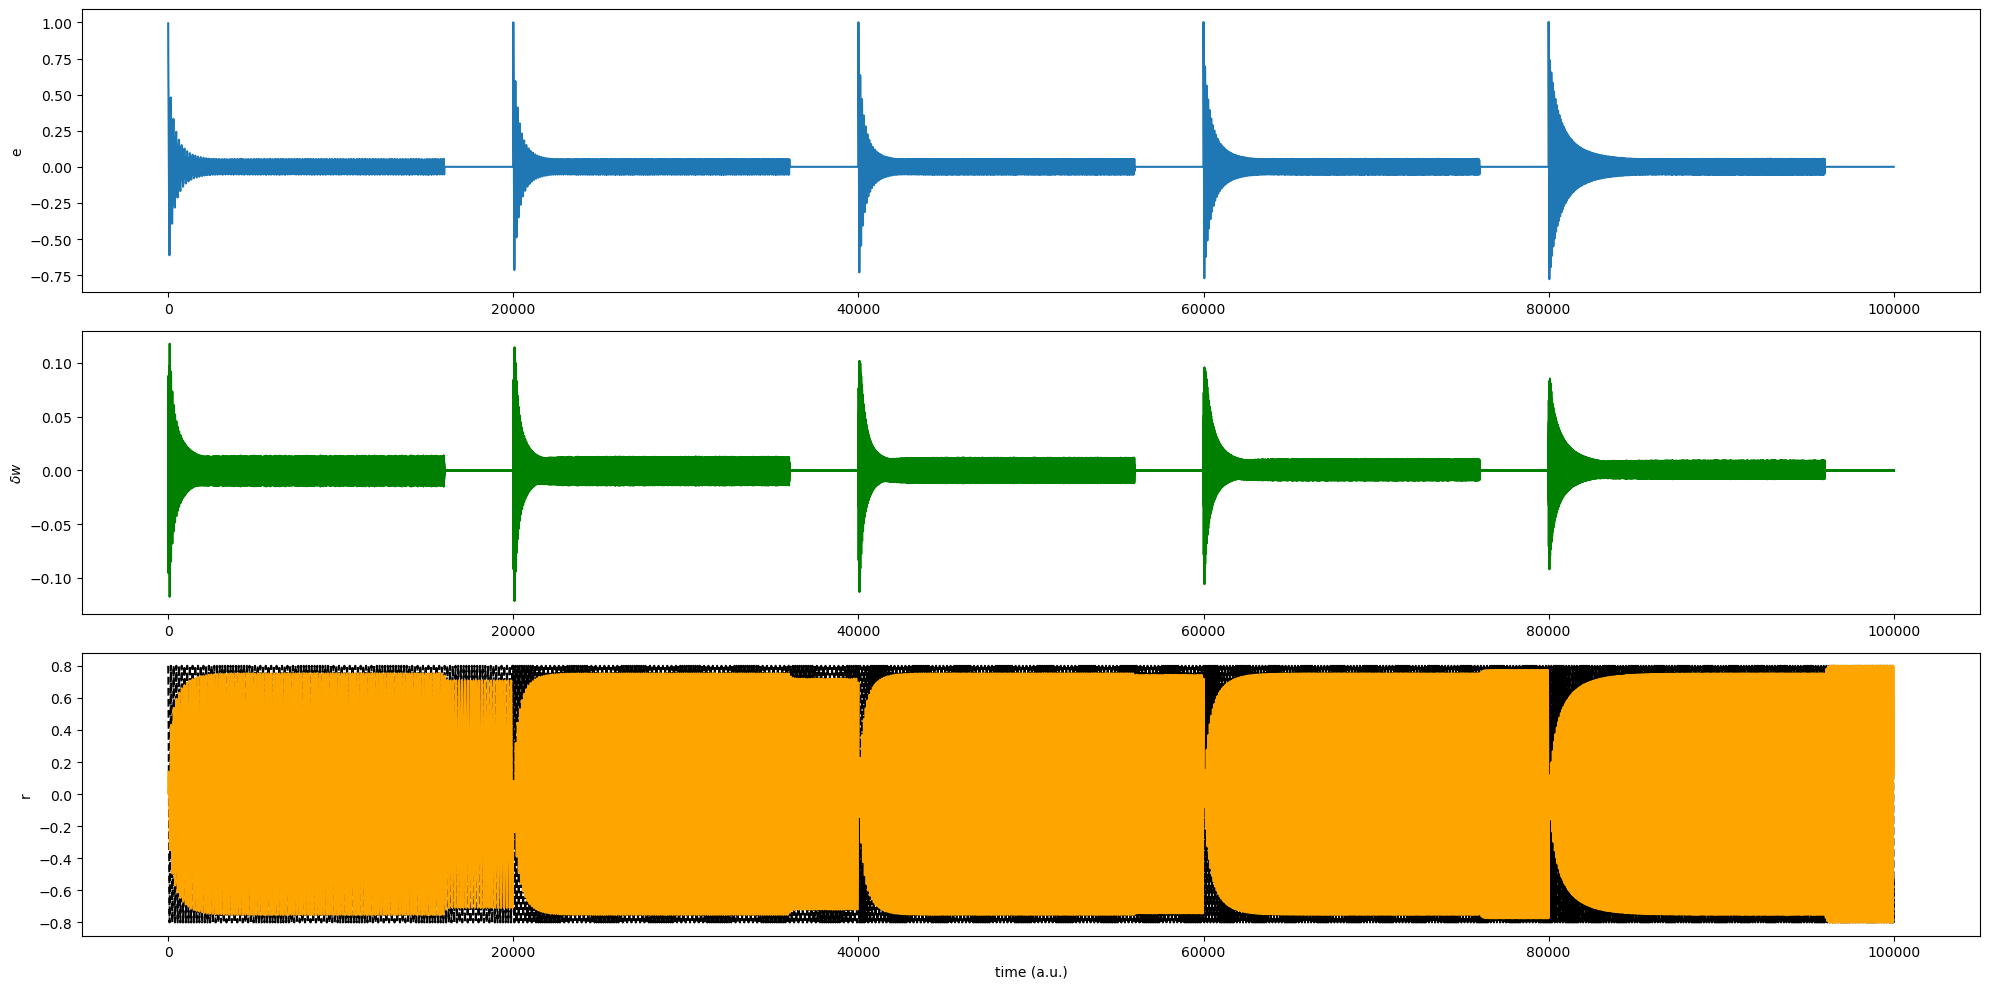

In [16]:
plt.figure(figsize=(20,10))

plt.subplot(311)

plt.plot(np.array(e_traj))
plt.ylabel('e')

plt.subplot(312)

plt.plot(dw_traj,'g')
plt.ylabel('$\delta w$')

plt.subplot(313)

plt.plot(r_targ,'k--')
plt.plot(r_traj,'orange')

plt.ylabel('r')
plt.xlabel('time (a.u.)')

plt.tight_layout()
plt.savefig('Fig1B_pretraining.png')
plt.savefig('Fig1B_pretraining.pdf')


Text(0, 0.5, 'actual readout')

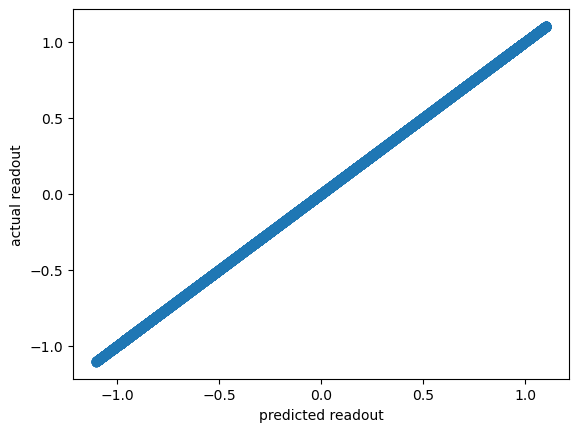

In [17]:
noise_size = 0.000005
W_out = np.linalg.pinv(x_net_coll + np.random.normal(0,noise_size,size= np.shape(x_net_coll) ) ).dot((y_coll))

network_reservoire.Jout = np.copy(W_out.T)
plt.scatter(W_out.T@np.array(x_net_coll).T,y_coll)

plt.xlabel('predicted readout')
plt.ylabel('actual readout')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0, 0.5, 'actual gradient')

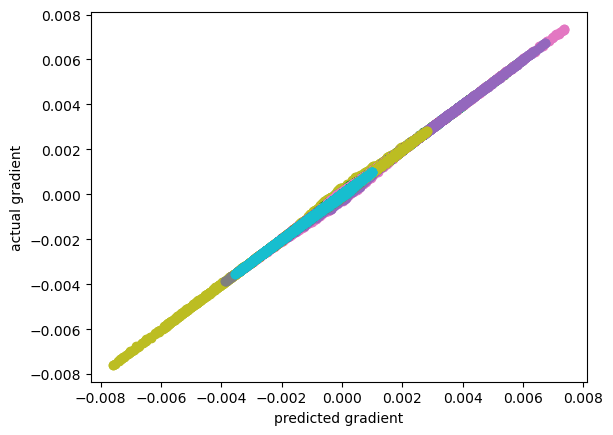

In [18]:
noise_size = 0.0000005

n_steps = np.shape(np.array(y_grad_coll))[1]

for k in range(n_steps):
    print(k)
    W_out = np.linalg.pinv(x_grad_net_coll + np.random.normal(0,noise_size,size= np.shape(x_grad_net_coll) ) ).dot(np.arctanh(np.array(y_grad_coll)[:,k]))
    network_reservoire_gradient.Jout[k,:] = np.copy(W_out.T)
    plt.scatter(np.tanh(W_out.T@np.array(x_grad_net_coll).T),np.array(y_grad_coll)[:,k])

plt.xlabel('predicted gradient')
plt.ylabel('actual gradient')


In [19]:
dw = 0

training_fraction = 0.9

r_traj_ = []
e_traj_ = []
dw_traj_ = []
r_targ_ = []
y_data_ = []
S = []

x_net_coll_ = []
y_coll_ = []

x_grad_net_coll_ = []
y_grad_coll_ = []

x_w_coll = []
y_w_coll = []

time_tot= 5000

dt = 0.1

omega_targ = 0.055

network_reservoire_y.reset()
network_reservoire.reset()
network_reservoire_gradient.reset()

eta = 0.01

network_reservoire_y.y = np.array(np.random.normal(0,1.,(1,)))
network_reservoire_y.Jout = network_reservoire_y.Jout*0.
w = np.copy(network_reservoire_y.Jout)
T = 200


f1 = np.random.uniform(1.,1.5)
f2 = np.random.uniform(1.,1.5)

a1 = np.random.uniform(-.5,.5)
a2 = 1.-np.abs(a1)

a1 = a1*0.8
a2 = a2*0.8

phi = np.random.uniform(0,2.*np.pi)

error = 0

#y_targ = 0
y_targ = np.cos(0)

dw = np.zeros(np.shape(w))

for k in range(500):
   
    if k>-1:
        input = np.copy( network_reservoire_y.y )

    network_reservoire_y.step_rate(input,sigma_S)

    encoded_e = encode(0)
    input = np.concatenate((encoded_e , np.reshape(network_reservoire_y.S , (np.shape(network_reservoire_y.S)[0],1  ) ) )  )#np.concatenate(( network_reservoire_y.S , encoded_e ))
    input= np.reshape(input,(np.shape(input)[0],))
    input_modulation = 1 + gamma_grad*network_reservoire_gradient.Jin_mult*e
    input_modulation= np.reshape(input_modulation,(np.shape(input_modulation)[0],))

    network_reservoire_gradient.step_rate(input,input_modulation,0)

    input = np.concatenate((network_reservoire_y.S.reshape(np.shape(network_reservoire_y.S)[0],1),w.T))
    input= np.reshape(input,(np.shape(input)[0],))
            
    input_modulation = 1 + gamma*network_reservoire.Jin_mult@w.T
    input_modulation= np.reshape(input_modulation,(np.shape(input_modulation)[0],))
    network_reservoire.step_rate(input,input_modulation.T,0)

y_pred=np.array([0])

for k in range(time_tot):

    state = np.cos(k*omega_targ)*.8
    y_targ_old = np.copy(y_targ)

    time_ = np.mod(((k/T*2*np.pi)) , 2*np.pi)

    y_targ = state

    r_targ_.append(y_targ )
    data_ndx = np.copy(k)

    S.append(network_reservoire_y.S)

    y_data.append(y_targ)

    if k<(time_tot*training_fraction):
        input = np.copy( np.array([ y_targ_old ]  ) )
        input = input + np.random.normal(0,sigma_res_noise,np.shape(input))

    else:
        input = y_pred
    
    network_reservoire_y.step_rate(input,sigma_S)

    e = y_targ_old - y_pred

    if k>time_tot*training_fraction:
        error = error + e**2

    if k>time_tot*training_fraction:
        e = e*0

    encoded_e = encode(e)
    input = np.concatenate((encoded_e , np.reshape(network_reservoire_y.S , (np.shape(network_reservoire_y.S)[0],1  ) ) )  )
    input= np.reshape(input,(np.shape(input)[0],))
    input_modulation = 1 + gamma_grad*network_reservoire_gradient.Jin_mult*e
    input_modulation= np.reshape(input_modulation,(np.shape(input_modulation)[0],))

    network_reservoire_gradient.step_rate(input,input_modulation,0)

    dw =  network_reservoire_gradient.y

    if k<time_tot*training_fraction:
        w = w + dw
    
    input = np.concatenate((network_reservoire_y.S.reshape(np.shape(network_reservoire_y.S)[0],1),w.T))
    input= np.reshape(input,(np.shape(input)[0],))
            
    input_modulation = 1 + gamma*network_reservoire.Jin_mult@w.T
    input_modulation= np.reshape(input_modulation,(np.shape(input_modulation)[0],))
    network_reservoire.step_rate(input,input_modulation.T,0)
    
    network_reservoire_y.Jout = np.copy(w)

    y_pred = network_reservoire_y.y
    if k>-100:
        y_pred = network_reservoire.y
    
    y_pred_net = network_reservoire.y
    x_net_coll_.append(network_reservoire_y.S)
    y_coll_.append(y_pred)

    x_grad_net_coll_.append(network_reservoire_gradient.S)
    y_grad_coll_.append(dw)

    r_traj_.append(y_pred_net)
    e_traj_.append(e)
    dw_traj_.append(dw)


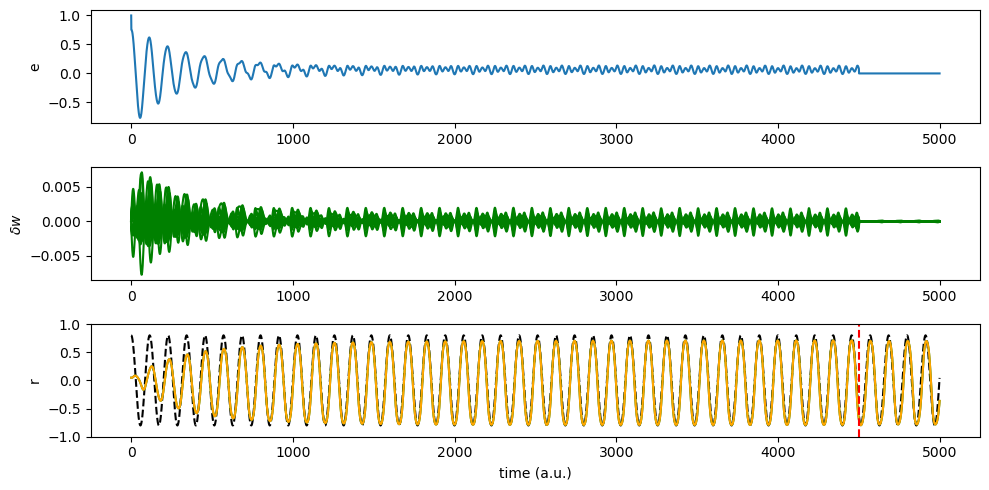

In [20]:

plt.figure(figsize=(10,5))

plt.subplot(311)

plt.plot(np.array(e_traj_))
plt.ylabel('e')

plt.subplot(312)

plt.plot(dw_traj_,'g')
plt.ylabel('$\delta w$')

plt.subplot(313)
plt.plot(r_targ_,'k--')
plt.plot(y_coll_,'green')

plt.plot(r_traj_,'orange')
plt.plot([time_tot*training_fraction,time_tot*training_fraction ],[-1,1],'r--')

plt.ylim(-1.,1.)
plt.ylabel('r') 
plt.xlabel('time (a.u.)')

plt.tight_layout()

plt.savefig('Fig1B.png')
plt.savefig('Fig1B.pdf')


In [21]:
dw = 0

training_fraction = 0.95

r_traj_ = []
e_traj_ = []
dw_traj_ = []
r_targ_ = []
y_data_ = []
S = []

x_net_coll_ = []
y_coll_ = []

x_grad_net_coll_ = []
y_grad_coll_ = []

x_w_coll = []
y_w_coll = []

time_tot= 10000

dt = 0.1

Errors = []

omega_vals = np.linspace(0.02,0.1,20)

for omega_targ in omega_vals:

    network_reservoire_y.reset()
    network_reservoire.reset()
    network_reservoire_gradient.reset()

    eta = 0.01

    network_reservoire_y.y = np.array(np.random.normal(0,1.,(1,)))
    network_reservoire_y.Jout = network_reservoire_y.Jout*0.
    w = np.copy(network_reservoire_y.Jout)
    T = 200

    error = 0

    y_targ = np.cos(0)

    dw = np.zeros(np.shape(w))

    for k in range(500):
    
        if k>-1:
            input = np.copy( network_reservoire_y.y )

        network_reservoire_y.step_rate(input,sigma_S)

        encoded_e = encode(0)
        input = np.concatenate((encoded_e , np.reshape(network_reservoire_y.S , (np.shape(network_reservoire_y.S)[0],1  ) ) )  )
        input= np.reshape(input,(np.shape(input)[0],))
        input_modulation = 1 + gamma_grad*network_reservoire_gradient.Jin_mult*e
        input_modulation= np.reshape(input_modulation,(np.shape(input_modulation)[0],))

        network_reservoire_gradient.step_rate(input,input_modulation,0)
        
        input = np.concatenate((network_reservoire_y.S.reshape(np.shape(network_reservoire_y.S)[0],1),w.T))
        input= np.reshape(input,(np.shape(input)[0],))
            
        input_modulation = 1 + gamma*network_reservoire.Jin_mult@w.T
        input_modulation= np.reshape(input_modulation,(np.shape(input_modulation)[0],))
        network_reservoire.step_rate(input,input_modulation.T,0)

    y_pred=np.array([0])

    for k in range(time_tot):

        state = np.cos(k*omega_targ)*.8
        y_targ_old = np.copy(y_targ)

        y_targ = state
        r_targ_.append(y_targ )
        data_ndx = np.copy(k)

        S.append(network_reservoire_y.S)

        y_data.append(y_targ)

        if k<(time_tot*training_fraction):
            input = np.copy( np.array([ y_targ_old ]  ) )
            input = input + np.random.normal(0,sigma_res_noise,np.shape(input))

        else:
            input = y_pred

        network_reservoire_y.step_rate(input,sigma_S)

        e = y_targ_old - y_pred

        if k>time_tot*training_fraction:
            error = error + e**2

        if k>time_tot*training_fraction:
            e = e*0

        encoded_e = encode(e)
        input = np.concatenate((encoded_e , np.reshape(network_reservoire_y.S , (np.shape(network_reservoire_y.S)[0],1  ) ) )  )
        input= np.reshape(input,(np.shape(input)[0],))
        input_modulation = 1 + gamma_grad*network_reservoire_gradient.Jin_mult*e
        input_modulation= np.reshape(input_modulation,(np.shape(input_modulation)[0],))

        network_reservoire_gradient.step_rate(input,input_modulation,0)

        dw =  network_reservoire_gradient.y

        if k<time_tot*training_fraction:
            w = w + dw
        
        input = np.concatenate((network_reservoire_y.S.reshape(np.shape(network_reservoire_y.S)[0],1),w.T))
        input= np.reshape(input,(np.shape(input)[0],))
            
        input_modulation = 1 + gamma*network_reservoire.Jin_mult@w.T
        input_modulation= np.reshape(input_modulation,(np.shape(input_modulation)[0],))
        network_reservoire.step_rate(input,input_modulation.T,0)
        
        network_reservoire_y.Jout = np.copy(w)

        y_pred = network_reservoire_y.y
        if k>-100:
            y_pred = network_reservoire.y
        
        y_pred_net = network_reservoire.y
        x_net_coll_.append(network_reservoire.S)
        y_coll_.append(y_pred)

        x_grad_net_coll_.append(network_reservoire_gradient.S)
        y_grad_coll_.append(dw)

        r_traj_.append(y_pred_net)
        e_traj_.append(e)
        dw_traj_.append(dw)
    Errors.append(error)
    
print(e)


[-0.]


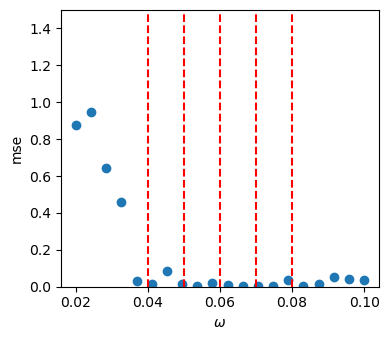

In [22]:
plt.figure(figsize=(4,3.5))
plt.plot(omega_vals,np.array(Errors)/(time_tot*(1-training_fraction)),'o')

# Define the positions of the vertical lines
vertical_lines = np.copy(omega_vals_train)
mses = np.copy(np.array(Errors)/(time_tot*(1-training_fraction)))

np.save('mses' + str(n_rep) + '.npy',mses)
np.save('omega_vals' + str(n_rep) + '.npy',omega_vals)

# Plot the vertical lines
for line in vertical_lines:
    plt.axvline(x=line, color='r', linestyle='--')

plt.ylabel('mse')
plt.ylim(0,1.5)
#plt.yscale('log')
plt.xlabel('$\omega$')

plt.tight_layout()

plt.savefig('Fig1C.png')
plt.savefig('Fig1C.pdf')
